In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
from cuml.cluster import KMeans
import cudf
import time

In [2]:
df = pd.read_csv("chembl_100k.smi",sep=" ",header=None)

In [3]:
df.columns = ["SMILES","Name"]

In [4]:
df.head()

,SMILES,Name
0,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,CHEMBL6329
1,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,CHEMBL6328
2,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,CHEMBL265667
3,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,CHEMBL6362
4,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,CHEMBL267864


In [5]:
def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp_list.append(fp_as_array(mol,n_bits))
        else:
            fp_list.append(None)
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [6]:
fp_list = fp_list_from_smiles_list(df.SMILES,1024)

In [7]:
df['fp'] = fp_list

In [8]:
df[df.fp.isna()]

,SMILES,Name,fp


In [9]:
df.head()

,SMILES,Name,fp
0,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,CHEMBL6329,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,CHEMBL6328,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,CHEMBL265667,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,CHEMBL6362,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,CHEMBL267864,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [10]:
df.shape

(100000, 3)

In [11]:
df.dropna(inplace=True)

In [12]:
df.shape

(100000, 3)

In [13]:
def np2cudf(arr):
    # convert numpy array to cudf dataframe
    df = pd.DataFrame({'fea%d'%i:arr[:,i] for i in range(arr.shape[1])})
    pdf = cudf.DataFrame()
    for c,column in enumerate(df):
        pdf[str(c)] = df[column]
    return pdf

In [14]:
desc = np.array(list(df.fp),dtype=np.float32)

In [15]:
cu_df = np2cudf(desc)

In [16]:
list(range(1000,11000,1000))

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

**WARNING** - The cell below performs some benchmark testing that takes about 6 minutes to run on a V1000.  Skip this if you don't want to wait for a few minutes.

In [17]:
rt_list = []
for n_clusters in tqdm(range(1000,11000,1000)):
    start = time.time()
    km = KMeans(n_clusters=n_clusters)
    km_res = km.fit_predict(cu_df)
    rt_list.append([n_clusters, time.time()-start])

Some settings to make the the plots appeal to my aesthetic sensibilities. 

In [54]:
sns.set(rc={'figure.figsize': (7, 7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

Make some plots

[Text(0, 0.5, 'Runtime (sec)'), Text(0.5, 0, 'Number of Clusters')]

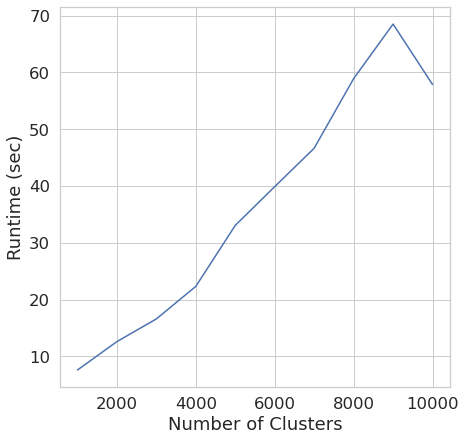

In [55]:
x = [x[0] for x in rt_list]
y = [x[1] for x in rt_list]
ax = sns.lineplot(x,y)
ax.set(xlabel="Number of Clusters",ylabel="Runtime (sec)")

In [64]:
km = KMeans(n_clusters=1000)
%time km_res = km.fit_predict(cu_df)
cluster_ids = km_res.to_array()

CPU times: user 6.72 s, sys: 4.53 s, total: 11.2 s
Wall time: 11.2 s


In [65]:
df['cluster'] = cluster_ids

In [66]:
df.head()

,SMILES,Name,fp,cluster
0,CCOC(=O)C(Cc1cc(c(c(c1)I)Oc2cc(c(c(c2)I)O)I)I)...,1815067837,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",53
1,CC[C@@H](C)[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)...,1815998278,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",919
2,C(C1[C@H](C(C([C@H](O1)Br)O[Ac])O[Ac])O[C@H]2C...,1815069026,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",420
3,CC(C)c1cccc(c1n2ccn(c2=[Ag]Cl)c3c(cccc3C(C)C)C...,292616769,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",864
4,C(=O)(OO)[Ag][Ag],1816712482,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3


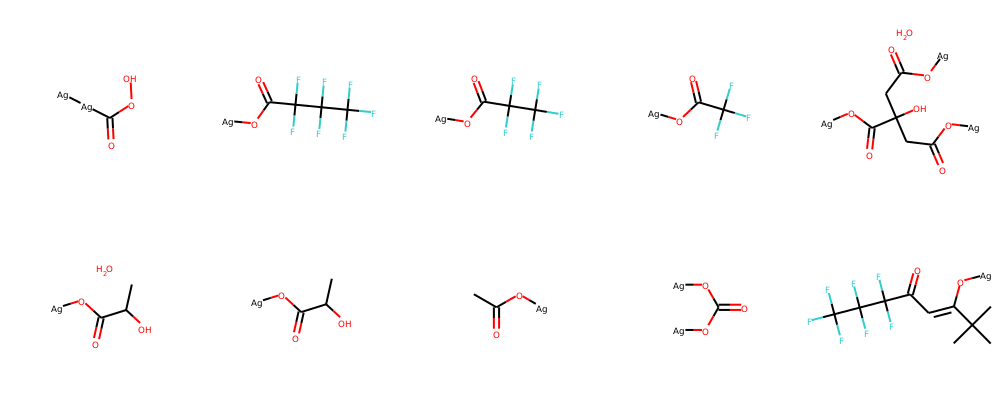

In [67]:
MolsToGridImage([Chem.MolFromSmiles(x) for x in df.query('cluster == 3').SMILES[:10]],molsPerRow=5)

In [124]:
dbs = DBSCAN(eps = 4, min_samples = 3)

In [125]:
dbs_pred = dbs.fit_predict(cu_df)

In [126]:
dbs_clusters = dbs_pred.to_array()

In [127]:
len(pd.Series(dbs_clusters).unique())

1659

In [113]:
df.query('cluster == 3')

,SMILES,Name,fp,cluster
4,C(=O)(OO)[Ag][Ag],1816712482,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
32,C(=O)(C(C(C(F)(F)F)(F)F)(F)F)O[Ag],187813254,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
33,C(=O)(C(C(F)(F)F)(F)F)O[Ag],185119992,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
34,C(=O)(C(F)(F)F)O[Ag],30404525,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
35,C(C(=O)O[Ag])C(CC(=O)O[Ag])(C(=O)O[Ag])O.O,34437584,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
...,...,...,...,...
47678,C=CC(=O)OCc1c(c(c(c(c1Br)Br)Br)Br)Br,68591796,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
47685,CC(=C)C(=O)Oc1c(c(c(c(c1Br)Br)Br)Br)Br,28801708,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
47686,C=CC(=O)Oc1c(c(c(c(c1Br)Br)Br)Br)Br,28801863,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
47747,C=CCOC(=O)c1c(c(c(c(c1Br)Br)Br)Br)C(=O)OCC=C,28801696,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3


In [115]:
a = desc[32]
b = desc[33]
dist = np.linalg.norm(a-b)
dist

2.4494898